In [1]:
import jax
import jax.numpy as jnp
from jax import grad, random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def load_image_as_matrix(image_path):
    image = Image.open(image_path).convert('L')
    return np.array(image)

def model(v, X, V1):
    M = jnp.dot(X.T, X) / (X.shape[0] - 1)  # Includes normalization
    reward = jnp.dot(v.T, jnp.dot(M, v))
    penalty = 0.0
    for j in range(V1.shape[1]):
        if jnp.linalg.norm(V1[:, j]) > 0:
            penalty_contribution = jnp.dot(v.T, jnp.dot(M, V1[:, j])) ** 2 / \
                                   jnp.dot(V1[:, j].T, jnp.dot(M, V1[:, j]))
            penalty += penalty_contribution
    utility = reward - penalty
    return utility[0, 0]

def update(v, X, V1, lr=0.01):
    dv = grad(model)(v, X, V1)
    v = v + lr * dv
    return v / jnp.linalg.norm(v)

def calc_eigengame_eigenvectors(X, n, iterations=100):
    X = jnp.array(X)
    rows, _ = X.shape
    V1 = jnp.zeros((rows, n))
    for k in range(n):
        key = random.PRNGKey(k)
        v = random.normal(key, (rows, 1))
        v = v / jnp.linalg.norm(v)
        for _ in range(iterations):
            v = update(v, X, V1, lr=0.01)
        V1 = V1.at[:, k].set(v.squeeze())
    return V1

def calc_eigengame_eigenvalues_scaled(X, V1):
    N = X.shape[0]  # Number of observations
    M = jnp.dot(X.T, X) / (N - 1)  # Apply scaling factor to the covariance matrix
    eigenvalues = jnp.array([jnp.dot(V1[:, k].T, jnp.dot(M, V1[:, k])) for k in range(V1.shape[1])])
    return eigenvalues

def numpy_eig(X):
    cov_matrix = np.dot(X.T, X) / (X.shape[0] - 1)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    return eigenvalues, eigenvectors


image_path = '/content/drive/MyDrive/cameraman.tif'
X = load_image_as_matrix(image_path)

# Compute Eigengame eigenvectors and eigenvalues (with adjusted scaling for eigenvalues)
V1 = calc_eigengame_eigenvectors(X, 2, iterations=100)
eigenvalues_scaled = calc_eigengame_eigenvalues_scaled(X, V1)

# Calculate using NumPy for comparison
X_np = np.array(X)  # Convert JAX array to NumPy array for compatibility
numpy_eigenvalues, numpy_eigenvectors = numpy_eig(X_np)

# Compare
print("Comparing Eigenvalues (with adjusted scaling for EigenGame):")
print("Eigengame:", eigenvalues_scaled)
print("NumPy:", numpy_eigenvalues[:len(eigenvalues_scaled)])


V1_np = np.array(V1)
V1_np_normalized = V1_np / np.linalg.norm(V1_np, axis=0)
numpy_eigenvectors_normalized = numpy_eigenvectors[:, :V1_np.shape[1]] / np.linalg.norm(numpy_eigenvectors[:, :V1_np.shape[1]], axis=0)
dot_products = np.abs(np.diagonal(np.dot(V1_np_normalized.T, numpy_eigenvectors_normalized)))
print("Dot products between corresponding eigenvectors (close to 1 indicates alignment):")
print(dot_products)


Comparing Eigenvalues (with adjusted scaling for EigenGame):
Eigengame: [128.59439    9.216447]
NumPy: [128.59441338   9.236706  ]
Dot products between corresponding eigenvectors (close to 1 indicates alignment):
[0.99999989 0.98788288]


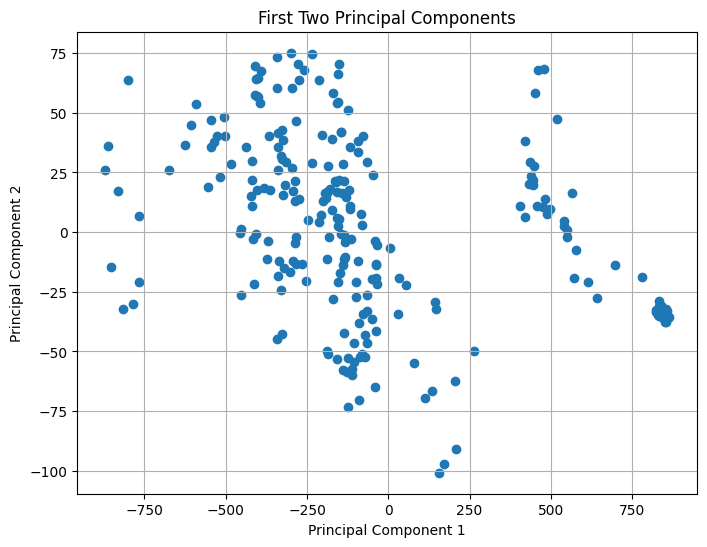

In [2]:
# Ensuring data is centered
X_centered = X - X.mean(axis=0)

# Project data onto the eigenvectors
principal_components = np.dot(X_centered, V1)

pc1 = principal_components[:, 0]
pc2 = principal_components[:, 1]

# Plotting the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(pc1, pc2, alpha=1)  # Adjust alpha to control point opacity
plt.title('First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()